In [102]:
% matplotlib inline
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

class SumNode:
    def __init__(self, id):
        self.id = id;
        self.children = []
        self.parents = []
        self.weights = []
        self.rank = 0
        self.Trank = 0
        
class PrdNode:
    def __init__(self, id):
        self.id = id
        self.children = []
        self.parents = []
        self.rank = 0
        self.TRank = 0
        
class Leaf:
    def __init__(self, id, a, b, i):
        self.id = id;
        self.inp = i;
        self.children = []
        self.parents = [];
        self.weights = [a, b];
        self.rank = 1;
        self.TRank = 0;
        
class SPN:
    def __init__(self, f):
        self.loss = None
        self.optimizer = None
        self.w_nodes, self.w_edges = self.split_up_file(f) #get the node and edge strings from file
        self.leaf_id, self.prod_id, self.sum_id, self.id_node_dict = self.build_nodes(self.w_nodes) #build node objects
        self.add_connections(self.w_edges)
        self.rank = self.add_ranks()
        self.node_layers = self.create_layers()
        self.pos_dict = self.make_pos_dict()
        self.leaf_id_order, self.input_layers, self.input_order = self.clean_up_inputs()
        self.inputs = None
        self.normed_everyhing = None
        self.outputs = None
        self.sess = None
        self.normalizer = None
        self.input_placeholders = []
        self.variables = []
        self.sparse_tensors = []
        self.build_graph()
        self.data = []
        
    def load_data_from_file(self, fname):
        D = open(fname, 'r')
        Data = []
        i = 'lol'
        while (i != ''):
            i = D.readline()
            if i == '':
                break;
            Data.append((map(lambda x: [int(x), 0] if int(x) == 1 else [int(x), 1], i.split(','))))
        oD = np.array(Data[:16181])
        oD = oD[:, self.input_order, :]
        oD = np.reshape(oD, (len(oD), oD.shape[1]*oD.shape[2]))
        self.data = oD
    
    def start_sess(self):
        assert self.sess == None
        self.init = tf.initialize_all_variables()
        self.sess = tf.Session()
        self.sess.run(self.init)
        
    def close_sess(self):
        assert self.sess != None
        self.sess.close()
        self.sess = None
    
    def predict(self, inp):
        assert self.sess != None
        print self.outputs.eval(session=self.sess, feed_dict = {self.inputs: inp})
    
    def train(self, data=[], epochs=50):
        assert self.sess != None
        if data == []:
            data = self.data
        ndata = np.array(data)
        loss_his = []
        for e in xrange(epochs):
            _, loss, preds = self.sess.run([self.optimizer, self.norm_loss, self.outputs], feed_dict={self.inputs: ndata})
            loss_his.append(loss)
            display.clear_output(wait=True)  
            plt.plot(loss_his, 'r')
            plt.show()
            print loss
            print preds
    def build_input_matrix(self, leafs):
        inds = []
        ws = []
        s = []
        for i in range(len(leafs)):
            node = self.id_node_dict[str(leafs[i])]
            a = float(node.weights[0])
            b = float(node.weights[1])
            inds.append([i, i*2])
            inds.append([i, i*2+1])
            ws.append(a)
            ws.append(b)
        s = [len(leafs), len(leafs)*2]
        return tf.Variable(ws, dtype=tf.float64), tf.constant(s, dtype=tf.int64), tf.constant(inds, dtype=tf.int64)
    
    def build_graph(self):
        #inputs
        given_input = tf.placeholder(dtype=tf.float64, shape=(len(self.input_order)*2, None))
        my_ones = tf.constant([[1]]*len(self.input_order)*2, dtype=tf.float64)
        self.inputs = given_input
        input_w, input_s, input_i = self.build_input_matrix(self.leaf_id_order)
        input_splits = []
        norm_splits = []
        input_mat = tf.SparseTensor(input_i, tf.identity(tf.nn.relu(input_w)), input_s)
        inp_comp = tf.sparse_tensor_dense_matmul(input_mat, given_input)
        norm_comp = tf.sparse_tensor_dense_matmul(input_mat, my_ones)
        j = 0
        for il in self.input_layers:
            input_splits.append(inp_comp[j:j+il])
            norm_splits.append(norm_comp[j:j+il])
            j += il
        curr = input_splits[0]
        norm = norm_splits[0]
        #compute layers
        L = 1
        Vars = []
        Inds = []
        for n_l in self.node_layers[1:]:
            #build vars:
            inds = []
            ws = []
            shape = []
            for i in range(len(n_l)-self.input_layers[L]):
                for j in range(len(n_l[i].children)):
                    a, b = self.pos_dict[n_l[i].children[j]]
                    inds.append([i, b])
                    if isinstance(n_l[i], SumNode): 
                        ws.append(float(n_l[i].weights[j]))
                    else:
                        ws.append(1.0)
            shape = [len(n_l)-self.input_layers[L], len(self.node_layers[L-1])]
            W = tf.Variable(ws, dtype=tf.float64)
            I = tf.constant(inds, dtype=tf.int64)
            S = tf.constant(shape, dtype=tf.int64)
            mat = tf.SparseTensor(I, tf.nn.relu(W), S)
            if isinstance(n_l[0], SumNode):
                norm = tf.concat(0, [tf.sparse_tensor_dense_matmul(mat, norm), norm_splits[L]])
                curr = tf.concat(0, [tf.sparse_tensor_dense_matmul(mat, curr), input_splits[L]])
            else:
                curr = tf.exp(tf.sparse_tensor_dense_matmul(mat, tf.log(curr)))
                norm = tf.exp(tf.sparse_tensor_dense_matmul(mat, tf.log(norm)))
            L += 1
            self.variables.append(W)
            self.sparse_tensors.append(mat)
        self.outputs = tf.add(curr, 0.0001)
        self.normalizer = norm
        norm_val = norm[0][0]
        self.normed_everything = tf.div(self.outputs, norm_val)
        self.loss = -tf.reduce_mean(tf.log(self.outputs))
        self.norm_loss = -tf.reduce_mean(tf.log(self.normed_everything))
        self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)
    
    def get_norm(self):
        print self.normalizer.eval(session=self.sess)
    
    def clean_up_inputs(self):
        input_layers = []
        input_order = []
        leaf_order = []
        for n_lst in self.node_layers:
            c = 0
            for n in n_lst:
                if isinstance(n, Leaf):
                    c += 1
                    input_order.append(int(n.inp))
                    leaf_order.append(n.id)
            input_layers.append(c)
        return leaf_order, input_layers, input_order
    
    def make_pos_dict(self):
        new_dict = {}
        for i in range(len(self.node_layers)):
            self.node_layers[i].sort(lambda x, y: 1 if isinstance(x, Leaf) else -1)
            for j in range(len(self.node_layers[i])):
                new_dict[self.node_layers[i][j].id] = (i, j)
        return new_dict
    
    def create_layers(self):
        node_list = [[] for x in range(self.rank)]
        for k in self.id_node_dict.keys():
            n = self.id_node_dict[k]
            node_list[n.TRank].append(n)
        return node_list[1:]
    
    def add_ranks(self):
        currs = set(self.leaf_id)
        rank = 1
        while len(currs) > 0:
            prev_currs = currs
            new_currs = set()
            for s in list(currs):
                for p in self.id_node_dict[s].parents:
                    new_currs.add(p)
                self.id_node_dict[s].rank = rank
            currs = new_currs
            rank += 1
        orank = rank
        rank -= 1
        currs = prev_currs
        while len(currs) > 0:
            new_currs = set()
            for s in list(currs):
                for p in self.id_node_dict[s].children:
                    new_currs.add(p)
                self.id_node_dict[s].TRank = rank
            currs = new_currs
            rank -= 1
        return orank
    
    def add_connections(self, edgez):
        for e in edgez :
            a = e.split(',')
            if a[0] == '' or a[1] == '':
                continue
            self.id_node_dict[a[0]].children.append(a[1])
            self.id_node_dict[a[1]].parents.append(a[0])
            if len(a) == 3:
                self.id_node_dict[a[0]].weights.append(a[2])
        
    def split_up_file(self, f):
        infile = open(f, 'r')
        t = 1
        lines = []
        while t != '':
            t = infile.readline()
            lines.append(t[:-1])
        n = 0
        for i in range(len(lines)):
            if "EDGES" in lines[i]:
                n = i;
                break;

        nodez = lines[1:n]
        edgez = lines[n+1:]
        return nodez, edgez
    
    def build_nodes(self, nodez):
        big_dict = {}
        Leaves = []
        Prods = []
        Sums = []
        for l in nodez:
            if 'PRD' in l:
                arr = l.split(',')
                node = PrdNode(arr[0])
                big_dict[arr[0]] = node
                Prods.append(arr[0])
        #         print 'hi'
            elif 'SUM' in l:
                arr = l.split(',')
                node = SumNode(arr[0])
                big_dict[arr[0]] = node
                Sums.append(arr[0])
            elif 'LEAVE' in l:
                arr = l.split(',')
                node = Leaf(arr[0], arr[3], arr[4], arr[2])
                big_dict[arr[0]] = node
                Leaves.append(arr[0])
        return Leaves, Prods, Sums, big_dict

In [103]:
S = SPN('nltcs.spncc.spn.txt')

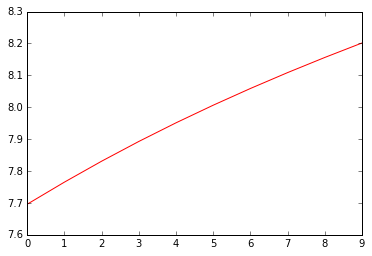

8.20155300485
[[ 0.04145372  0.00010617  0.00204129 ...,  0.00010053  0.00010052
   0.00010713]]


In [104]:
S.load_data_from_file('nltcs.ts.data')
S.start_sess()
S.predict([[1], [1]]*len(S.leaf_id))
S.get_norm()
S.train(S.data.T, 10)


In [105]:
S.norm_loss.eval(session=S.sess, feed_dict={S.inputs: S.data.T})

8.2450033316550861

In [20]:
S.close_sess()

In [22]:
D = open('nltcs.ts.data', 'r')

In [23]:
Data = []
i = 'lol'
while (i != ''):
    i = D.readline()
    if i == '':
        break;
    Data.append((map(lambda x: [int(x), 0] if int(x) == 1 else [int(x), 1], i.split(','))))

In [24]:
Data

[[[0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1]],
 [[0, 1],
  [0, 1],
  [0, 1],
  [1, 0],
  [0, 1],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [0, 1],
  [1, 0],
  [1, 0],
  [0, 1],
  [0, 1],
  [1, 0]],
 [[0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [1, 0],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1]],
 [[0, 1],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0]],
 [[0, 1],
  [0, 1],
  [1, 0],
  [1, 0],
  [0, 1],
  [1, 0],
  [1, 0],
  [1, 0],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 1]],
 [[0, 1],
  [0, 1],
  [0, 1],
  [1, 0],
  [1, 0],
  [1, 0],
  [0, 1],
  [1, 0],
  [0, 1],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [1, 0],
  [0, 1]],
 [[0, 1],
  [0, 1],
  [0, 1],
  [1

In [55]:
len(Data[0]), len(Data)

(1574, 16180)

In [56]:
len(S.prod_id)

142

In [30]:
nData = np.reshape(np.array(Data[:16181]), (16, 2, 16181))

In [41]:
nData

array([[[0, 1, 0, ..., 0, 1, 0],
        [1, 0, 1, ..., 0, 0, 1]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 1, ..., 1, 1, 0]],

       [[0, 1, 0, ..., 0, 1, 0],
        [1, 0, 1, ..., 1, 0, 1]],

       ..., 
       [[0, 1, 0, ..., 1, 0, 1],
        [0, 1, 0, ..., 1, 1, 0]],

       [[0, 1, 0, ..., 0, 1, 0],
        [1, 0, 1, ..., 1, 0, 1]],

       [[0, 1, 0, ..., 1, 0, 1],
        [0, 1, 0, ..., 1, 0, 1]]])

In [51]:
a

In [52]:
oD = np.array(Data[:16181])
oD = oD[:, S.input_order, :]
oD = np.reshape(oD, (len(oD), oD.shape[1]*oD.shape[2]))

787 1574
